In [1]:
%load_ext autoreload
%autoreload 2

# Case study of circuits in same functional but different evolutionary regimes

## Imports

In [2]:

from functools import partial
from typing import Optional, Tuple
import os
import sys
import numpy as np
import jax
import jax.numpy as jnp
import diffrax as dfx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pink_palette = sns.cubehelix_palette(rot=0.5, start=2.7, gamma=1.1)

jax.config.update('jax_platform_name', 'gpu')
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="0.70" 

if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from bioreaction.simulation.manager import simulate_steady_states
from synbio_morpher.srv.io.manage.script_manager import script_preamble
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from synbio_morpher.utils.misc.helper import vanilla_return
from synbio_morpher.utils.misc.numerical import add_recursively
from synbio_morpher.utils.misc.type_handling import append_nest_dicts
from synbio_morpher.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols
from synbio_morpher.utils.results.analytics.timeseries import generate_analytics
from synbio_morpher.utils.common.testing.shared import CONFIG
from synbio_morpher.utils.common.setup import construct_circuit_from_cfg, prepare_config
from synbio_morpher.utils.circuit.agnostic_circuits.circuit_manager import CircuitModeller

CONFIG = prepare_config(CONFIG)
root_dir = '..'

## Load data

In [3]:
fn = '../data/ensemble_mutation_effect_analysis/2023_07_17_105328/summarise_simulation/tabulated_mutation_info.csv'
data = pd.read_csv(fn)
data = data.drop(data[data['sample_name'].isna()].index)

config = load_json_as_dict(os.path.join(fn.split('summarise')[0], 'mutation_effect_on_interactions_signal', 'experiment.json'))
config = config['config_filepath']
config['experiment']['purpose'] = 'tests'


## Find 2 circuits

In [4]:
def find_similar_distant_circuits(similars: tuple, distants: tuple, weights: Optional[tuple]=None, uselog=True) -> Tuple[int]:
    def calculate_diffs(og):
        similars_diff = f(og[:, None] / og[None, :])
        return np.where(np.isnan(similars_diff) | (np.abs(similars_diff) == np.inf), 0, similars_diff)
    
    if weights is None:
        weights = np.ones(len(similars) * len(distants))
    f = np.log if uselog else vanilla_return

    similars_diffs = [calculate_diffs(similar) for similar in similars]
    distants_diffs = [calculate_diffs(distant) for distant in distants]
        
    joint_similars = np.zeros(similars_diffs[0].shape)
    for d, w in zip(similars_diffs, weights[:len(similars)]):
        joint_similars += w * np.abs(d)
    joint_similars = np.where(joint_similars != 0, joint_similars.max() - np.abs(joint_similars), 0)
        
    joint_distants = np.zeros(distants_diffs[0].shape)
    for d, w in zip(distants_diffs, weights[len(similars):]):
        joint_distants += w * np.abs(d)

    joint = joint_similars + joint_distants

    circ1, circ2 = np.where(joint == np.abs(joint).max()) 
    circ1, circ2 = np.array(list(set([tuple(sorted([c1, c2])) for c1, c2 in zip(circ1, circ2)]))).T
    
    return circ1, circ2


In [66]:
analytics = [c for c in get_true_names_analytics(data) if ('sensitivity' in c) or ('precision' in c) or ('overshoot' in c)]
agg1_stds_muts = data.groupby(['circuit_name', 'sample_name'], as_index=False).agg({c: lambda x: np.std(np.log10(x)) if (sum(x) != 0.0) and (sum(x) != np.inf) else 0.0 for c in analytics + ['num_interacting', 'num_self_interacting']})
agg1_mean_muts = data.groupby(['circuit_name', 'sample_name'], as_index=False).agg({c: lambda x: np.mean(np.log10(x)) if (sum(x) != 0.0) and (sum(x) != np.inf) else 0.0 for c in analytics + ['num_interacting', 'num_self_interacting']})
agg1_mean_init = data[data['mutation_num'] == 0]

/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [83]:
species_selected = 'RNA_2'

### Display selected circuits

Text(0.5, 1.0, 'Sensitivity std')

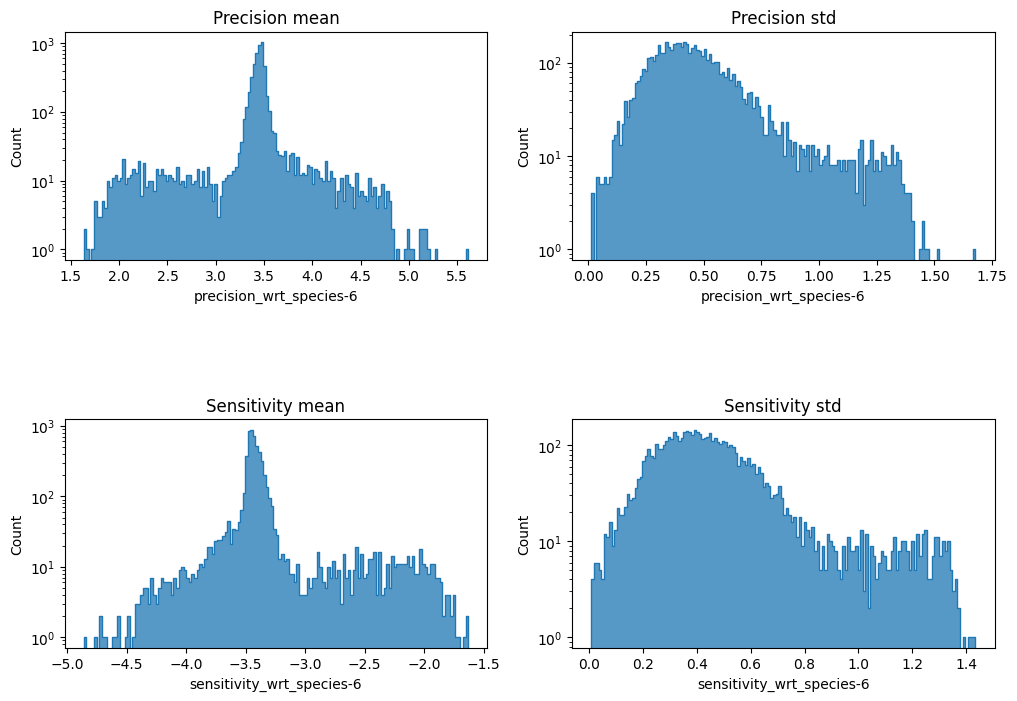

In [6]:
fig = plt.figure(figsize=(6*2, 2*4))
fig.subplots_adjust(hspace=0.7)

ax = plt.subplot(2,2,1)
sns.histplot(agg1_mean_muts[agg1_mean_muts['sample_name'] != 'RNA_0'], x='precision_wrt_species-6', element='step', bins=150, log_scale=[False, True])
plt.title('Precision mean')

ax = plt.subplot(2,2,2)
sns.histplot(agg1_stds_muts[agg1_stds_muts['sample_name'] != 'RNA_0'], x='precision_wrt_species-6', element='step', bins=150, log_scale=[False, True])
plt.title('Precision std')

ax = plt.subplot(2,2,3)
sns.histplot(agg1_mean_muts[agg1_mean_muts['sample_name'] != 'RNA_0'], x='sensitivity_wrt_species-6', element='step', bins=150, log_scale=[False, True])
plt.title('Sensitivity mean')

ax = plt.subplot(2,2,4)
sns.histplot(agg1_stds_muts[agg1_stds_muts['sample_name'] != 'RNA_0'], x='sensitivity_wrt_species-6', element='step', bins=150, log_scale=[False, True])
plt.title('Sensitivity std')

In [86]:
filts = (agg1_mean_muts['sample_name'] == species_selected) # & (agg1_mean_muts['precision_wrt_species-6'] != np.inf)
# filts = (agg1_mean_muts['sample_name'] == 'RNA_2') & (agg1_mean_muts['precision_wrt_species-6'] != np.inf) & (
#     agg1_mean_muts['precision_wrt_species-6'] > 2) & ((agg1_mean_muts['num_interacting'] > 1) | (agg1_mean_muts['num_self_interacting'] > 1))

circ1, circ2 = find_similar_distant_circuits(
    similars=[data[(data['sample_name'] == species_selected) & (data['mutation_num'] == 0) & (data['precision_wrt_species-6'] != np.inf)][s].to_numpy()
              for s in ['precision_wrt_species-6', 'sensitivity_wrt_species-6']],
    distants=[agg1_stds_muts[filts][s].to_numpy() for s in ['sensitivity_wrt_species-6']],
    # distants=[agg1_mean_muts[filts][s].to_numpy() for s in ['precision_wrt_species-6_ratio_from_mutation_to_base']],
    # weights=(1, 10, 0.15),
    weights=(1, 10, 0.1),
    uselog=False)


circ1_m_df = agg1_mean_muts[filts].iloc[circ1]
circ2_m_df = agg1_mean_muts[filts].iloc[circ2]
circ1_s_df = agg1_stds_muts[filts].iloc[circ1]
circ2_s_df = agg1_stds_muts[filts].iloc[circ2]

In [88]:
agg1_mean_muts

,circuit_name,sample_name,overshoot,precision_wrt_species-6,precision_wrt_species-6_diff_to_base_circuit,precision_wrt_species-6_ratio_from_mutation_to_base,sensitivity_wrt_species-6,sensitivity_wrt_species-6_diff_to_base_circuit,sensitivity_wrt_species-6_ratio_from_mutation_to_base,overshoot_diff_to_base_circuit,overshoot_ratio_from_mutation_to_base,num_interacting,num_self_interacting
0,toy_mRNA_circuit_0,RNA_0,0.592483,0.036624,-inf,0.010499,-9.117785e-10,-inf,-9.117785e-10,-inf,-0.501068,-inf,-inf
1,toy_mRNA_circuit_0,RNA_1,-inf,2.328912,-inf,0.912682,-2.144391e+00,-inf,-9.844862e-01,-inf,-inf,-inf,-inf
2,toy_mRNA_circuit_0,RNA_2,-inf,3.472157,-inf,-0.052118,-3.450683e+00,-inf,7.359166e-02,-inf,0.000000,-inf,-inf
3,toy_mRNA_circuit_10,RNA_0,-0.086085,0.022075,-inf,0.020916,-5.758601e-10,-inf,-5.758601e-10,-inf,0.186699,-inf,0.168136
4,toy_mRNA_circuit_10,RNA_1,-inf,3.456891,-inf,-0.034329,-3.441438e+00,-inf,4.978256e-02,-inf,0.000000,-inf,0.168136
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,toy_mRNA_circuit_12698,RNA_1,-inf,3.457115,-inf,-0.020196,-3.443468e+00,-inf,3.384358e-02,-inf,0.000000,-inf,-inf
8996,toy_mRNA_circuit_12698,RNA_2,-inf,3.457654,-inf,-0.019658,-3.445374e+00,-inf,3.193716e-02,-inf,0.000000,-inf,-inf
8997,toy_mRNA_circuit_12699,RNA_0,-0.113921,0.017332,-inf,0.016170,-1.439650e-10,-inf,-1.439650e-10,-inf,0.157549,-inf,-inf
8998,toy_mRNA_circuit_12699,RNA_1,-inf,3.498515,-inf,0.021203,-3.488304e+00,-inf,-1.099255e-02,-inf,0.000000,-inf,-inf


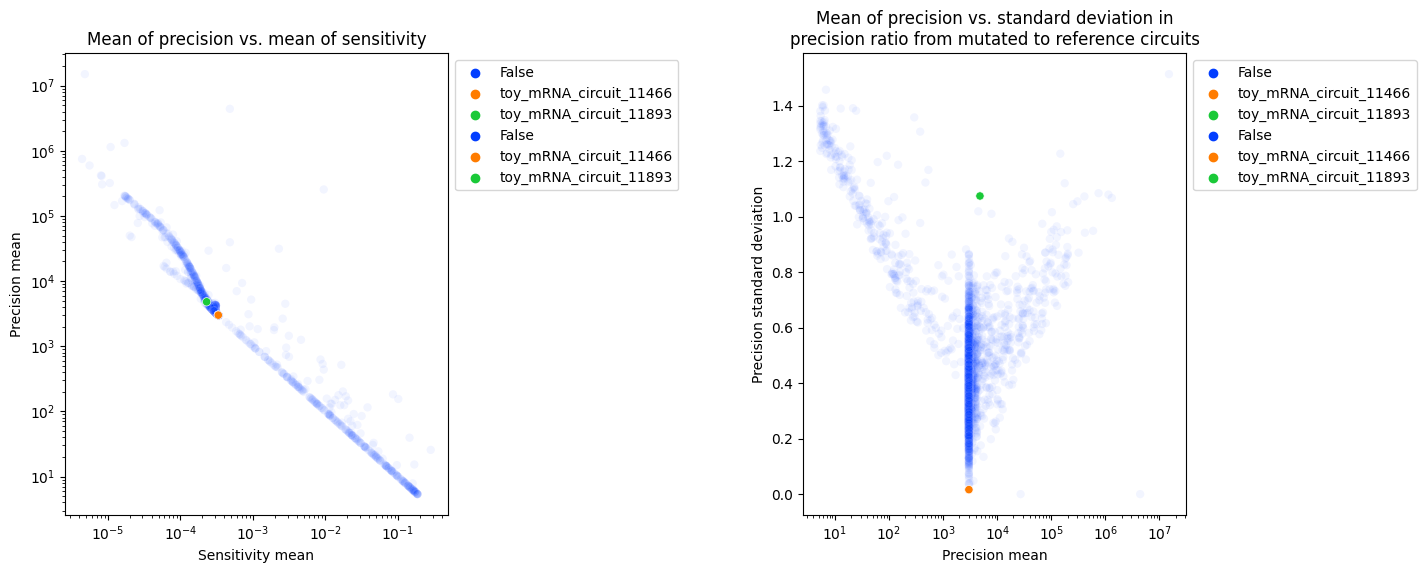

In [93]:
agg1_mean_init = data[data['mutation_num'] == 0].reset_index()
filt = (agg1_mean_muts['precision_wrt_species-6'] < np.inf) & (agg1_mean_muts['sample_name'] == species_selected)
hue = list(map(lambda i, c: c if (i == circ1_m_df.index[0]) or (i == circ2_m_df.index[0]) else False, 
               list(agg1_mean_muts[filt].index), list(agg1_mean_muts[filt]['circuit_name'].values)))
alpha = list(map(lambda x: 1 if x != False else 0.0005, hue))

fig = plt.figure(figsize=(8*3, 6))
fig.subplots_adjust(wspace=0.925)

ax = plt.subplot(1,3,1)
sns.scatterplot(agg1_mean_init[filt],
                x='sensitivity_wrt_species-6', 
                y='precision_wrt_species-6', 
                alpha=0.05,
                hue=hue,
                palette="bright")
sns.scatterplot(agg1_mean_init[filt],
                x='sensitivity_wrt_species-6', 
                y='precision_wrt_species-6', 
                alpha=alpha,
                hue=hue,
                palette="bright",
                )
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sensitivity mean')
plt.ylabel('Precision mean')
plt.title('Mean of precision vs. mean of sensitivity')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))

ax = plt.subplot(1,3,2)
sns.scatterplot(x=agg1_mean_init[filt]['precision_wrt_species-6'], y=agg1_stds_muts[filt]['precision_wrt_species-6'], 
                alpha=0.05,
                hue=hue,
                palette='bright')
sns.scatterplot(x=agg1_mean_init[filt]['precision_wrt_species-6'], y=agg1_stds_muts[filt]['precision_wrt_species-6'], 
                alpha=alpha,
                hue=hue,
                palette='bright')
plt.xlabel('Precision mean')
plt.ylabel('Precision standard deviation')
plt.xscale('log')
# plt.yscale('log')
plt.title('Mean of precision vs. standard deviation in\nprecision ratio from mutated to reference circuits')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))



Text(0.5, 0.98, 'Precision mean for $RNA_2$')

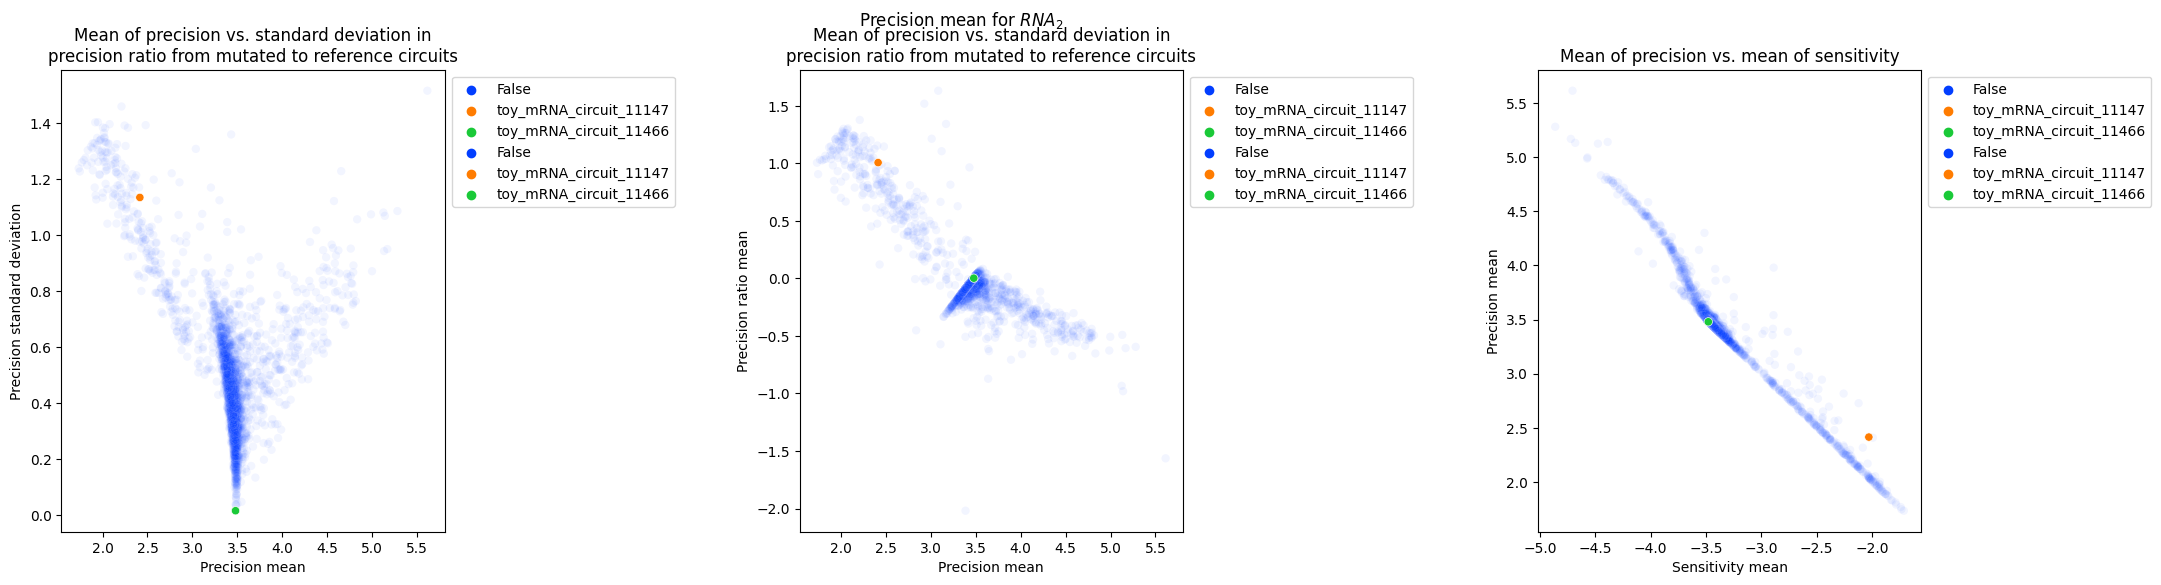

In [54]:
filt = (agg1_mean_muts['precision_wrt_species-6'] < np.inf) & (agg1_mean_muts['sample_name'] == species_selected)
hue = list(map(lambda i, c: c if (i == circ1_m_df.index[0]) or (i == circ2_m_df.index[0]) else False, 
               list(agg1_mean_muts[filt].index), list(agg1_mean_muts[filt]['circuit_name'].values)))
alpha = list(map(lambda x: 1 if x != False else 0.0005, hue))

fig = plt.figure(figsize=(8*3, 6))
fig.subplots_adjust(wspace=0.925)

ax = plt.subplot(1,3,1)
sns.scatterplot(x=agg1_mean_muts[filt]['precision_wrt_species-6'], y=agg1_stds_muts[filt]['precision_wrt_species-6'], 
                alpha=0.05,
                hue=hue,
                palette='bright')
sns.scatterplot(x=agg1_mean_muts[filt]['precision_wrt_species-6'], y=agg1_stds_muts[filt]['precision_wrt_species-6'], 
                alpha=alpha,
                hue=hue,
                palette='bright')
plt.xlabel('Precision mean')
plt.ylabel('Precision standard deviation')
# plt.xscale('log')
# plt.yscale('log')
plt.title('Mean of precision vs. standard deviation in\nprecision ratio from mutated to reference circuits')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))

ax = plt.subplot(1,3,2)
sns.scatterplot(x=agg1_mean_muts[filt]['precision_wrt_species-6'], y=agg1_mean_muts[filt]['precision_wrt_species-6_ratio_from_mutation_to_base'], 
                alpha=0.05,
                hue=hue,
                palette='bright')
sns.scatterplot(x=agg1_mean_muts[filt]['precision_wrt_species-6'], y=agg1_mean_muts[filt]['precision_wrt_species-6_ratio_from_mutation_to_base'], 
                alpha=alpha,
                hue=hue,
                palette='bright')
plt.xlabel('Precision mean')
plt.ylabel('Precision ratio mean')
# plt.xscale('log')
# plt.yscale('log')
plt.title('Mean of precision vs. standard deviation in\nprecision ratio from mutated to reference circuits')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))

filt = (agg1_mean_muts['precision_wrt_species-6'] < np.inf) & (agg1_mean_muts['sensitivity_wrt_species-6'] < np.inf) & (agg1_mean_muts['sample_name'] == 'RNA_2')
alpha = list(map(lambda x: 1 if x != False else 0.0005, hue))

ax = plt.subplot(1,3,3)
sns.scatterplot(agg1_mean_muts[filt],
                x='sensitivity_wrt_species-6', 
                y='precision_wrt_species-6', 
                alpha=0.05,
                hue=hue,
                palette="bright")
sns.scatterplot(agg1_mean_muts[filt],
                x='sensitivity_wrt_species-6', 
                y='precision_wrt_species-6', 
                alpha=alpha,
                hue=hue,
                palette="bright",
                )
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Sensitivity mean')
plt.ylabel('Precision mean')
plt.title('Mean of precision vs. mean of sensitivity')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))

plt.suptitle('Precision mean for $RNA_2$')



## Show their evolution

Text(0, 0.5, 'Sensitivity')

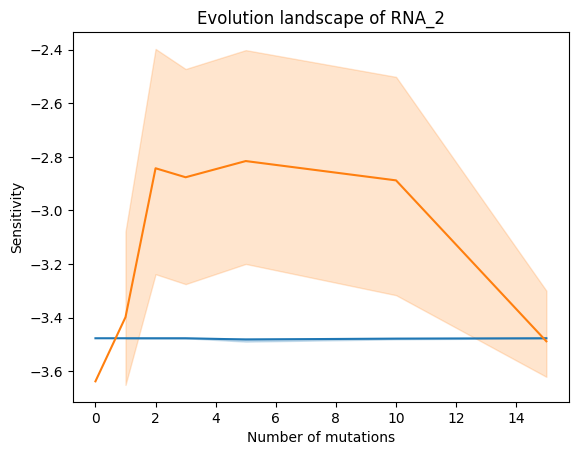

In [82]:
filt1 = (data['circuit_name'] == circ1_m_df['circuit_name'].iloc[0]) & (data['sample_name'] == species_selected)
sns.lineplot(data[filt1], x='mutation_num', y=np.log10(data[filt1]['sensitivity_wrt_species-6']))
filt2 = (data['circuit_name'] == circ2_m_df['circuit_name'].iloc[0]) & (data['sample_name'] == species_selected)
sns.lineplot(data[filt2], x='mutation_num', y=np.log10(data[filt2]['sensitivity_wrt_species-6']))

plt.title(f'Evolution landscape of {species_selected}')
plt.xlabel('Number of mutations')
plt.ylabel('Sensitivity')